### Generating the dataset

In [1]:
srand(1)

# number of users
d1 = 10;

# number of items
d2 = 15;

# number of queries
n = 5000;

In [2]:
# generate the hidden ratings
ThetaS = rand(d1,3) * rand(3,d2)

# Need to have the sum of rows equaling 0
for i = 1:d1
    ThetaS[i,:] -= mean(ThetaS[i,:])
end

# Need to make the Frobenius norm < 1
ThetaS = ThetaS / vecnorm(ThetaS);

In [3]:
y = []
X = []

for i = 1:n
    Xi = zeros(d1, d2)
    
    lin = rand(1:d1)
    c1 = rand(1:d2)
    c2 = rand(1:d2)
    while c2 == c1
        c2 = rand(1:d2)
    end
    
    Xi[lin,c1] = 1
    Xi[lin,c2] = -1
    Xi = Xi * sqrt(d1 * d2)
    
    push!(X, Xi)
    
    if ThetaS[lin,c1] > ThetaS[lin,c2]
        push!(y, 1)
    else
        push!(y, 0)
    end
end

### Helper functions

In [4]:
function nucNorm(A)
    return sum(svd(A)[2])
end

nucNorm (generic function with 1 method)

In [5]:
# make sure the matrix is centered and with norm < 1

function adjust(X)
    ans = copy(X)
    
    for i = 1:d1
        ans[i,:] -= mean(ans[i,:])
    end
    
    return ans / vecnorm(ans)
end

adjust (generic function with 1 method)

In [6]:
# The objective loss function

function lossObj(Theta)
    ans = 0
    
    for i = 1:n
        ans = ans + log(1 + e^(trace(Theta' * X[i]))) - y[i] * trace(Theta' * X[i])
    end
    
    return ans / n
end

lossObj (generic function with 1 method)

In [7]:
# Compute the derivative of the objective loss

function deltaF(Theta)
    
    ans = zeros(d1,d2)
    
    for i = 1:n
        t1 = 1 / (1 + e^trace(Theta' * X[i]))
        t2 = e^trace(Theta' * X[i]) * X[i]
        t3 = y[i] * X[i]
        
        ans = ans + t1 * t2 - t3
    end
    
    return ans / n
    
end

deltaF (generic function with 1 method)

In [8]:
# The proximal objective

function proxObj(lambda, X, V)
    return lambda * nucNorm(X) + 1 / 2 * vecnorm(X - V)^2
end

proxObj (generic function with 1 method)

In [9]:
# # The proximal function
# # return the matrix X that minimizes lambda * ||X||_nuc + 1/(2 lambda_k) || X - V ||_F^2
# # equivalent to (lamda*lambda_k) ||X||_nuc + 1/2 || X - V ||_F^2

# function prox(lambda, V)
    
#     ans = zeros(d1,d2)
    
#     _,S,_ = svd(V)
#     S = max(S - lambda, 0)
    
#     for i = 1:length(S)
#         ans[i,i] = S[i]
#     end
    
#     return adjust(ans)
    
# end

In [10]:
# The proximal function
# return the matrix X that minimizes lambda * ||X||_nuc + 1/(2 lambda_k) || X - V ||_F^2
# equivalent to (lamda * lambda_k) ||X||_nuc + 1/2 || X - V ||_F^2

function prox(lambda, V)
    
    X = adjust(rand(d1,d2))
    Xmin = copy(X)
    
    step = 0.05
    eps = 1e-6
    numSteps = 0
    
    while numSteps < 500
        numSteps += 1
    
        # a subgradient of lambda * ||X||_nuc is AB' where X = ASB'
        A,_,B = svd(X)
        t1 = lambda * A * B'

        # the derivative of 1 / 2 || X - V ||_2^2 is (X - V)
        t2 = X - V
        
        newX = X - step * (t1 + t2)
        newX = adjust(newX)
        
        if proxObj(lambda, X, V) < eps
            return X
        end
        
        if proxObj(lambda, X, V) < proxObj(lambda, Xmin, V)
            Xmin = copy(X)
        end
        
        X = copy(newX)
    end
    
    return Xmin
    
end

prox (generic function with 1 method)

##### As a sanity check, make sure that our gradient steps indeed decreases obj loss

In [11]:
Theta = adjust(rand(d1,d2))

println("Hidden loss ", lossObj(ThetaS))
println("Current loss ", lossObj(Theta))

for stp = 1:100
    alpha = 0.05
    der = deltaF(Theta)

    newTheta = Theta - alpha * der
    newTheta = adjust(newTheta)

    if stp % 10 == 0
        println("Loss after ", stp, " steps: ", lossObj(newTheta))
    end
    
    Theta = copy(newTheta)
end

Hidden loss 0.3392539122124946
Current loss 0.9000772658412434
Loss after 10 steps: 0.7085470429419394
Loss after 20 steps: 0.5563863205198784
Loss after 30 steps: 0.454519457622993
Loss after 40 steps: 0.39227566303563854
Loss after 50 steps: 0.3554233611865242
Loss after 60 steps: 0.33375098161016875
Loss after 70 steps: 0.3209949635369063
Loss after 80 steps: 0.3134672281778019
Loss after 90 steps: 0.30901221213858004
Loss after 100 steps: 0.3063682436901998


#### Let's test out the algorithm

In [12]:
curX = adjust(rand(d1,d2))
lambda = 0.5
lambda_k = 0.02

LF = []

for steps = 1:300
    # first, go in the direction of F
    interX = curX - lambda_k * deltaF(curX)
    newX = prox(lambda * lambda_k, interX)
    
    if steps % 10 == 0
#         println("f + g = ", lossObj(curX) + lambda * nucNorm(curX))
#         println("f = ", lossObj(curX))
#         println("g = ", lambda * nucNorm(curX))
#         println(vecnorm(ThetaS - newX)^2)
#         println()
    end
    
    push!(LF, vecnorm(ThetaS - newX)^2)
    
    curX = copy(newX)
end

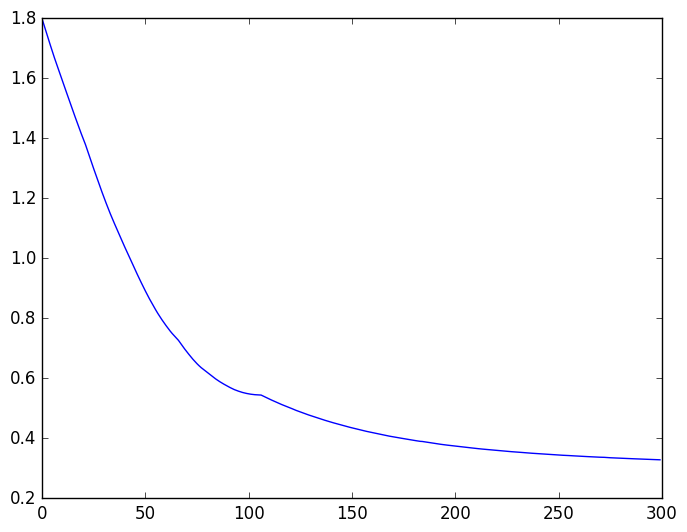

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x32089b150>

In [13]:
using PyPlot

# xkcd()
plot(LF)